## Classification task

In [212]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [213]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [214]:
### Helper functions
#plotPerColumnDistribution(df, nGraphShown, nGraphPerRow)
#plotCorrelationMatrix(df, graphWidth)
#plotScatterMatrix(df, plotSize, textSize)

### Getting CUP data into dataframe

In [215]:
import cv2
import glob

imdir = 'coffee_cup/images/'
ext = ['png', 'jpg', 'gif']    # Add image formats here

files = []
[files.extend(glob.glob(imdir + '*.' + e)) for e in ext]

cup_images = [cv2.imread(file) for file in files]

In [216]:
max_size = 0
for i, img in enumerate(cup_images):
    w, h,_ = img.shape
    if w>max_size:
        max_size=w
    if h>max_size:
        max_size=h
print(max_size)

1024


**SO the cups are not square**
- We can strecth or pad the images.
- Padding seems more safe as the final testing will have noise and occlusion anyways.

In [217]:
def alter_images(images, max_size, padding=False, output_size=128):
    altered_images = []
    for i, img in enumerate(images): # Resize
        # resize image
        w, h,_ = img.shape
        # Grayscale image
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if padding:
            # Add padding
            top=(max_size-h)//2
            bottom=(max_size-h)//2
            left=(max_size-w)//2
            right=(max_size-w)//2
            borderType=cv2.BORDER_CONSTANT # cv2.BORDER_WRAP
            value=[255, 255, 255] # White borders
            img_gray = cv2.copyMakeBorder(img_gray, top, bottom, left, right, borderType, value=value)
        # Finally We want a fixed-size image for input to ML
        altered_images.append(cv2.resize(img_gray, (output_size, output_size), interpolation = cv2.INTER_AREA))
    return altered_images   

cup_altered_images=alter_images(cup_images, max_size, padding=True)

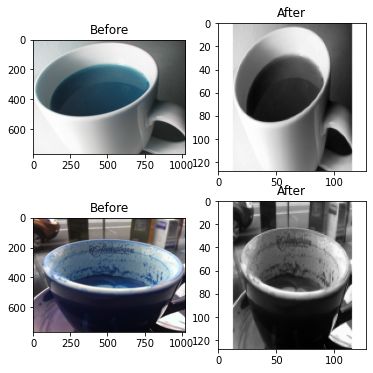

In [218]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
axs[0, 0].imshow(cup_images[0])
axs[0, 0].set_title("Before")
axs[0, 1].imshow(cup_altered_images[0], cmap="gray")
axs[0, 1].set_title("After")
axs[1, 0].imshow(cup_images[1])
axs[1, 0].set_title("Before")
axs[1, 1].imshow(cup_altered_images[1], cmap="gray")
axs[1, 1].set_title("After");


### Now add cardboard images as well!

In [219]:
imdir = 'cardboard/images/'
ext = ['png', 'jpg', 'gif']    # Add image formats here

files = []
[files.extend(glob.glob(imdir + '*.' + e)) for e in ext]

cb_images = [cv2.imread(file) for file in files]

In [220]:
max_size = 0
for i, img in enumerate(cup_images):
    w, h,_ = img.shape
    if w>max_size:
        max_size=w
    if h>max_size:
        max_size=h
print(max_size)
cb_altered_images=alter_images(cb_images, max_size, padding=False)

1024


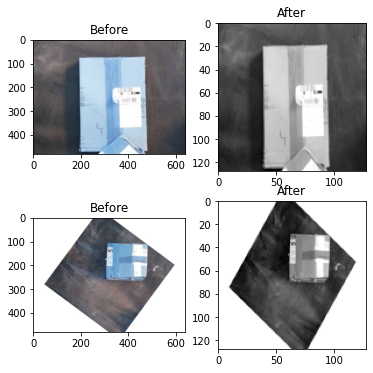

In [221]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
axs[0, 0].imshow(cb_images[0])
axs[0, 0].set_title("Before")
axs[0, 1].imshow(cb_altered_images[0], cmap="gray")
axs[0, 1].set_title("After")
axs[1, 0].imshow(cb_images[1])
axs[1, 0].set_title("Before")
axs[1, 1].imshow(cb_altered_images[1], cmap="gray")
axs[1, 1].set_title("After");


**Flatten images, and alter them for machine learning**

In [222]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Flatten cup, and turn into row vector
flat_cup = []
for i,matrix in enumerate(cup_altered_images):
    flat_cup.append(matrix.flatten())
flat_cup=np.asarray(flat_cup)
# Normalize
scaler = MinMaxScaler().fit(flat_cup)
flat_cup_scaled = scaler.transform(flat_cup)
# Reshape
r, c = flat_cup_scaled.shape
flat_cup_col=flat_cup_scaled.reshape((r, 1, c))
print(flat_cup_col.shape)

# Flatten cb, and turn into row vector
flat_cb = []
for i,matrix in enumerate(cb_altered_images):
    flat_cb.append(matrix.flatten())
flat_cb=np.asarray(flat_cb)
# Normalize
flat_cb_scaled = scaler.transform(flat_cb)
# Reshape
r, c = flat_cb_scaled.shape
flat_cb_col=flat_cb_scaled.reshape((r, 1, c))
print(flat_cb_col.shape)


(101, 1, 16384)
(179, 1, 16384)


In [223]:
df1 = pd.DataFrame({'Images':list(flat_cup_col), 'label': 0})
df1

df2 = pd.DataFrame({'Images':list(flat_cb_col), 'label': 1})
df2

frames = [df1, df2]
df = pd.concat(frames)
df

Images  label
0    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      0
1    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      0
2    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      0
3    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      0
4    [[0.8745098039215686, 0.8705882352941177, 0.87...      0
..                                                 ...    ...
174  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      1
175  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      1
176  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      1
177  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      1
178  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      1

[280 rows x 2 columns]

### Make a PCA dataframe as well

In [224]:
from sklearn.decomposition import PCA

In [225]:
pca_cup = PCA(n_components = 81) # We only need two first principle components (2D space)
pca_cb = PCA(n_components = 81) # We only need two first principle components (2D space)

cup_reduced = pca_cup.fit_transform(flat_cup)
cb_reduced = pca_cb.fit_transform(flat_cb)

# Normalize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
cup_reduced_scaled = MinMaxScaler().fit_transform(cup_reduced)
cb_reduced_scaled = MinMaxScaler().fit_transform(cb_reduced)

# Make 1D vectors into column-vectors
r, c = cup_reduced_scaled.shape
cup_reduced_scaled=cup_reduced_scaled.reshape((r, 1, c))
r, c = cb_reduced_scaled.shape
cb_reduced_scaled=cb_reduced_scaled.reshape((r, 1, c))

print("Cup PCA:",sum(pca_cup.explained_variance_ratio_))
print("Cb PCA:",sum(pca_cb.explained_variance_ratio_))



Cup PCA: 0.9858383113182752
Cb PCA: 0.9838259134354735


In [226]:
cb_reduced_scaled.shape

(179, 1, 81)

In [227]:
dfcup_pca = pd.DataFrame({'PCA': list(cup_reduced_scaled), 'label': 0})
dfcb_pca = pd.DataFrame({'PCA': list(cb_reduced_scaled), 'label': 1})

frames = [dfcup_pca, dfcb_pca]
df_PCA = pd.concat(frames)
df_PCA

PCA  label
0    [[0.4038429373781387, 0.23147586118170482, 0.4...      0
1    [[0.6518181017715189, 0.37112240812110164, 0.4...      0
2    [[0.5190004520771377, 0.2769262675196693, 0.26...      0
3    [[0.29470715774976763, 0.20297002275948237, 0....      0
4    [[0.4347645425299454, 0.6452493799067122, 0.49...      0
..                                                 ...    ...
174  [[0.3290602448532301, 0.5350106929726341, 0.62...      1
175  [[0.21312798942946742, 0.6911893892489127, 0.5...      1
176  [[0.1646462112662101, 0.598970612425205, 0.452...      1
177  [[0.024029562837751678, 0.3710489671011996, 0....      1
178  [[0.0019472158353897595, 0.2749196505337185, 0...      1

[280 rows x 2 columns]

## Classification

### First attempt: SVM on PCA reduced data. No validation split

In [228]:
from sklearn import datasets, svm, metrics
########## PARAMETERS #########
C = 1.0                     ### 
gamma = "scale" #Default    ### 
######## PARAMETERS ###########

#rbf_svc_classifier = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(df_PCA["PCA"], df_PCA["label"])

### Second attempt: ANN!

In [229]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=25) # 50
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def plot_history_loss(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Cross entropy loss')
    #plt.yscale("log")
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

def plot_history_acc(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Cross entropy accuracy')
    #plt.yscale("log")
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend()

In [230]:
np.stack(df_PCA['PCA'],0).shape

(280, 1, 81)

First data is Training on PCA data

In [231]:
# Model 1 Training on PCA data
pca_model = tf.keras.Sequential()
pca_model.add(layers.Dense(np.asarray(df_PCA["PCA"]).shape[0], activation=tf.nn.relu))
pca_model.add(layers.Dense(32, activation=tf.nn.relu))
pca_model.add(layers.Dense(2, activation=tf.nn.softmax)) 

pca_model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy']
              )

history = pca_model.fit(x=np.stack(df_PCA['PCA'],0),
                    y=np.float32(df_PCA["label"]),
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

pca_model.summary()


.................................................Epoch 00049: early stopping
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 1, 280)            22960     
_________________________________________________________________
dense_61 (Dense)             (None, 1, 32)             8992      
_________________________________________________________________
dense_62 (Dense)             (None, 1, 2)              66        
Total params: 32,018
Trainable params: 32,018
Non-trainable params: 0
_________________________________________________________________


In [232]:
hist1 = pd.DataFrame(history.history)
hist1['epoch'] = history.epoch
hist1.tail(1)

loss  accuracy  val_loss  val_accuracy  epoch
48  0.023536       1.0  0.013114           1.0     48

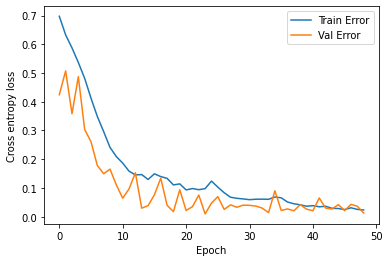

In [233]:
plot_history_loss(hist1)

**Training ANN on RAW image data**

In [238]:
# Model 2 Training on PCA data
raw_model = tf.keras.Sequential()
raw_model.add(layers.Dense(np.asarray(df_PCA["PCA"]).shape[0], activation=tf.nn.relu))
raw_model.add(layers.Dense(64, activation=tf.nn.relu))
raw_model.add(layers.Dense(2, activation=tf.nn.softmax)) 

raw_model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy']
              )

history = raw_model.fit(x=np.stack(df['Images'],0),
                    y=np.float32(df["label"]),
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


................................................Epoch 00048: early stopping


In [239]:
hist2 = pd.DataFrame(history.history)
hist2['epoch'] = history.epoch
hist2.tail(1)

loss  accuracy  val_loss  val_accuracy  epoch
47  0.043972  0.984127  0.053179      0.964286     47

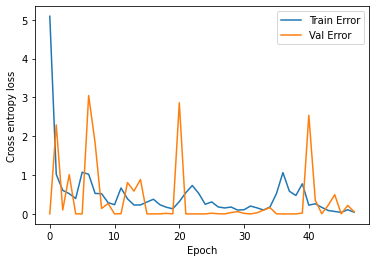

In [240]:
plot_history_loss(hist2)

C:\Users\henri\AppData\Local\Temp\ipykernel_25788\3242265234.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)


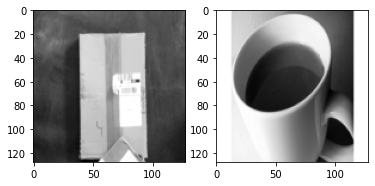

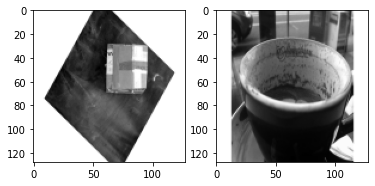

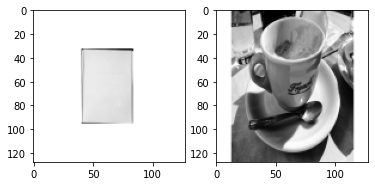

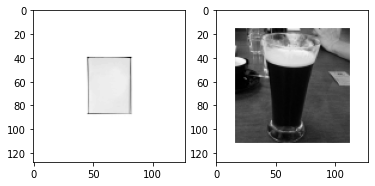

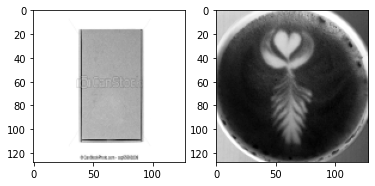

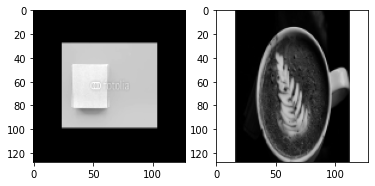

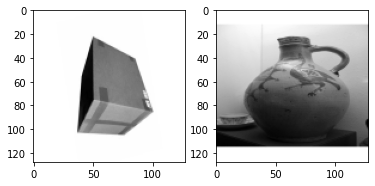

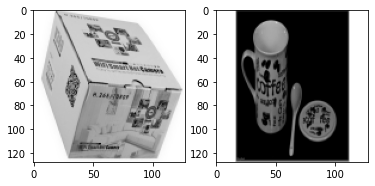

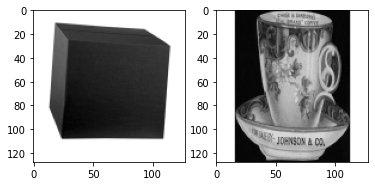

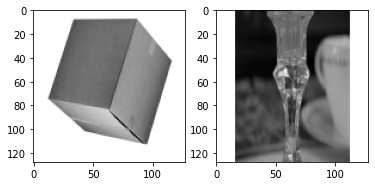

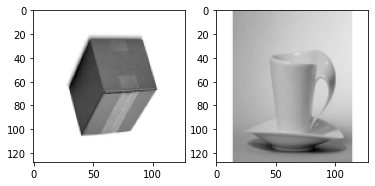

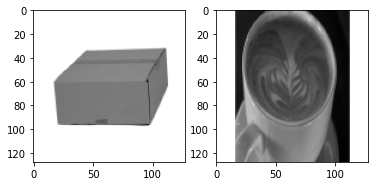

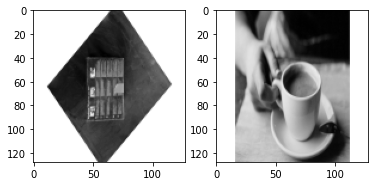

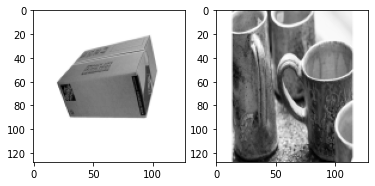

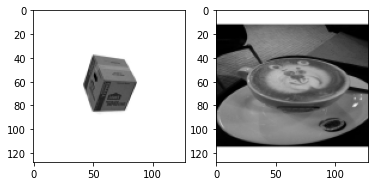

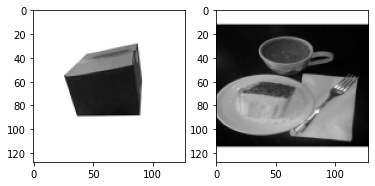

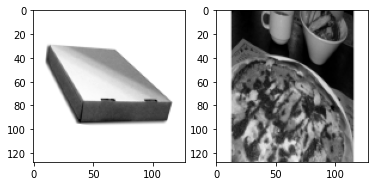

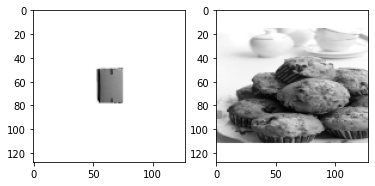

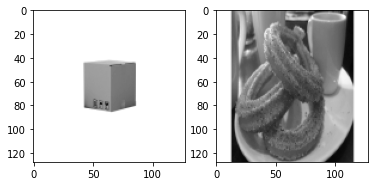

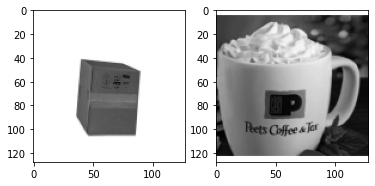

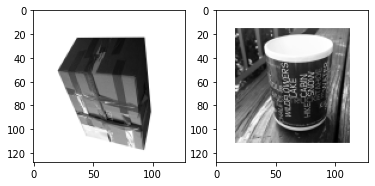

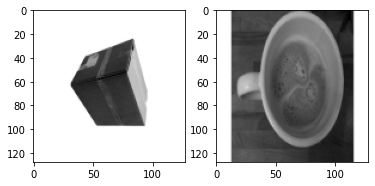

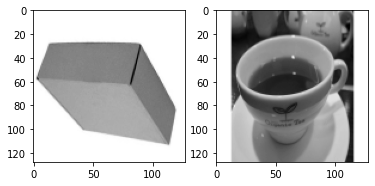

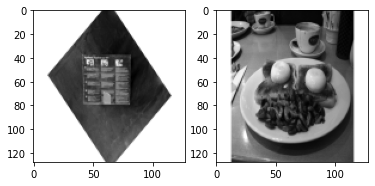

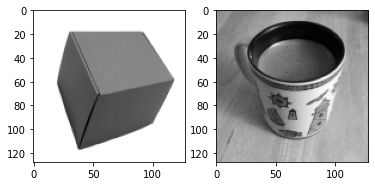

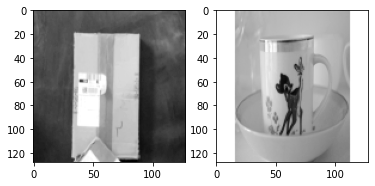

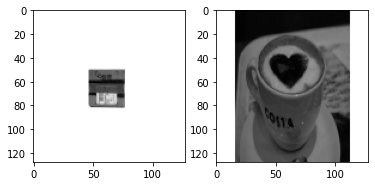

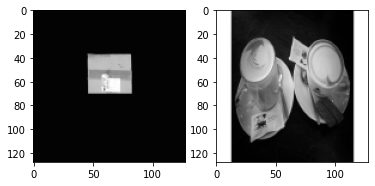

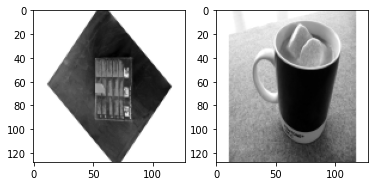

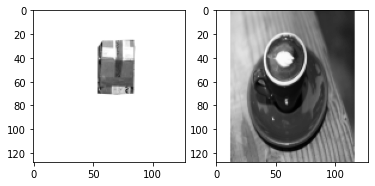

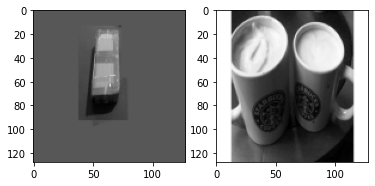

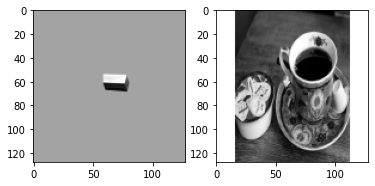

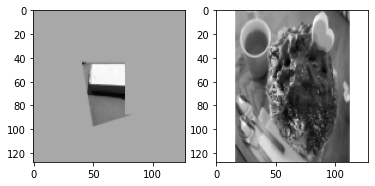

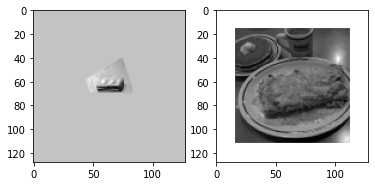

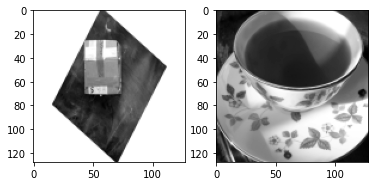

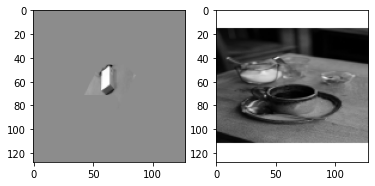

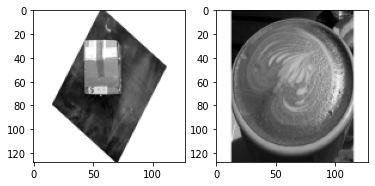

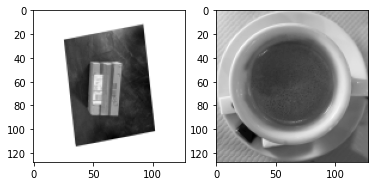

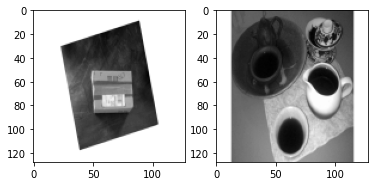

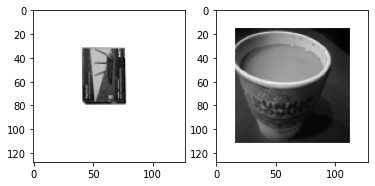

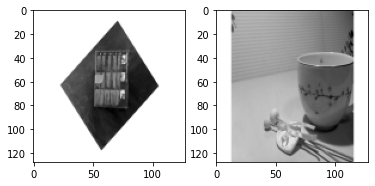

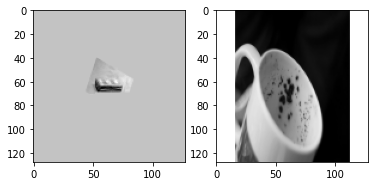

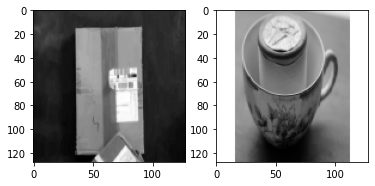

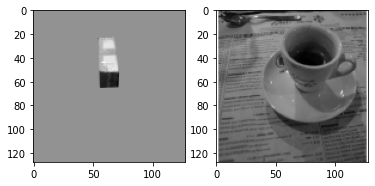

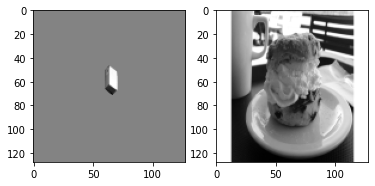

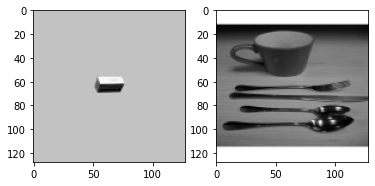

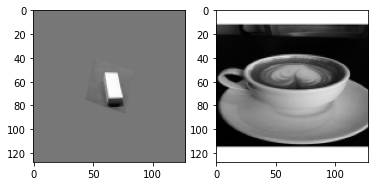

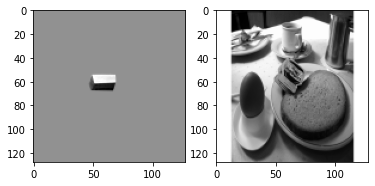

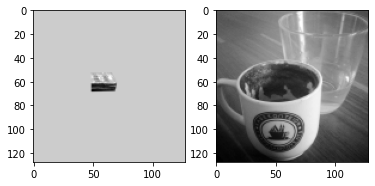

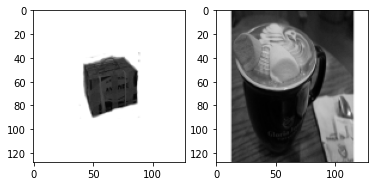

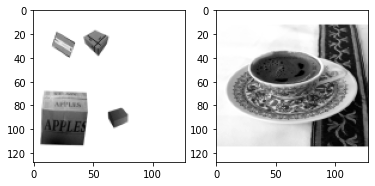

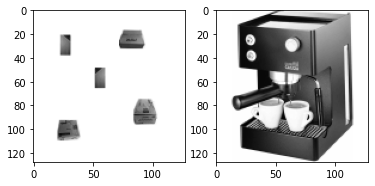

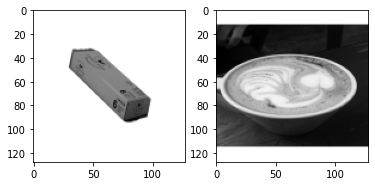

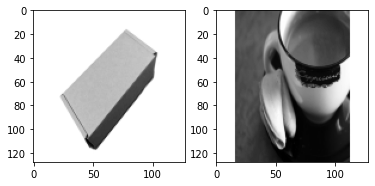

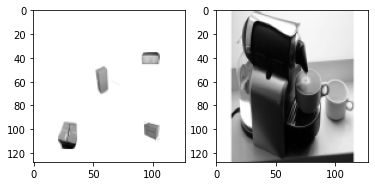

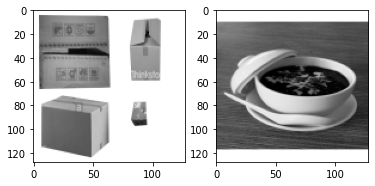

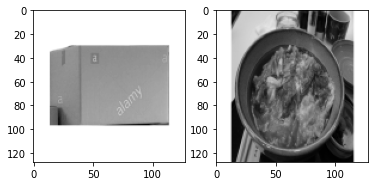

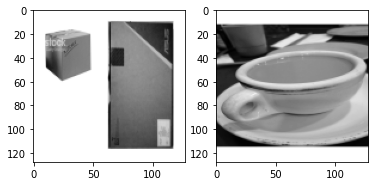

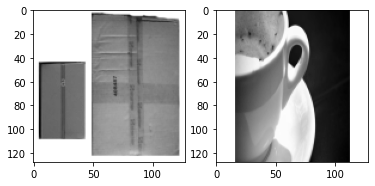

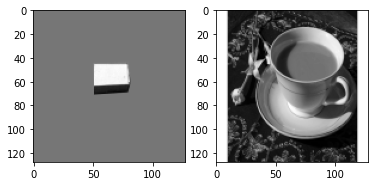

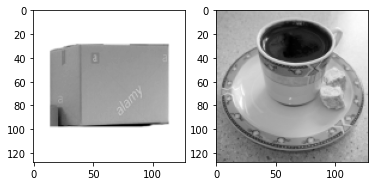

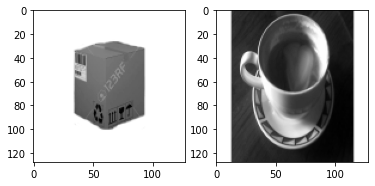

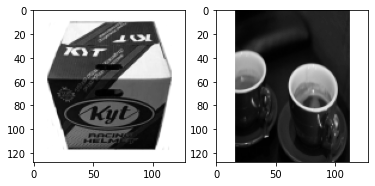

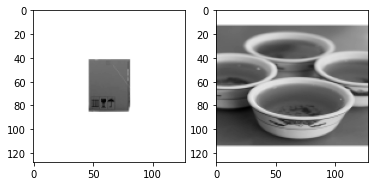

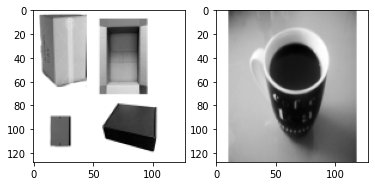

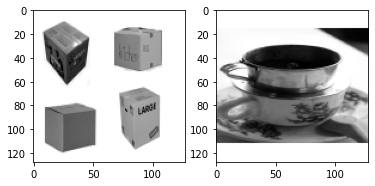

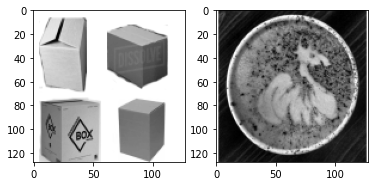

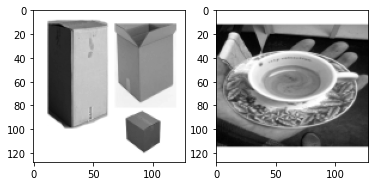

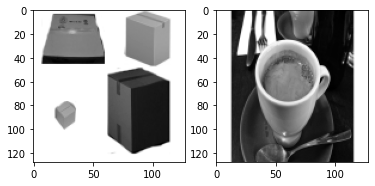

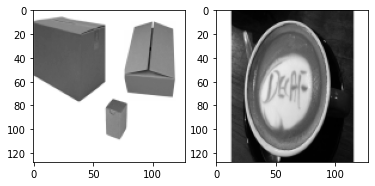

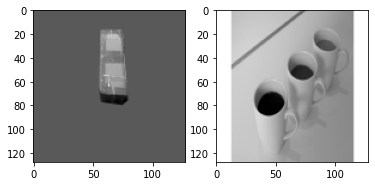

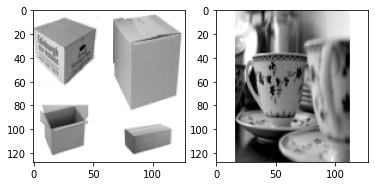

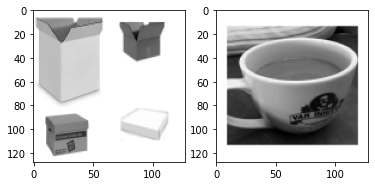

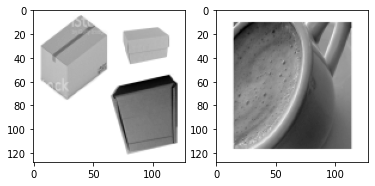

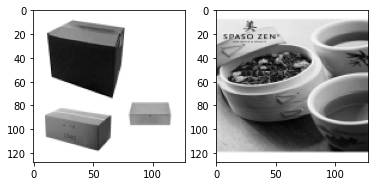

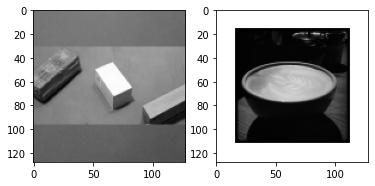

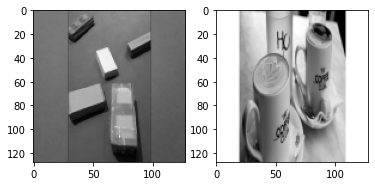

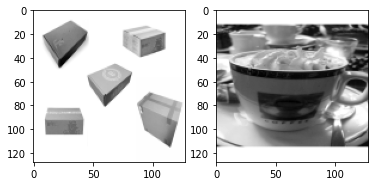

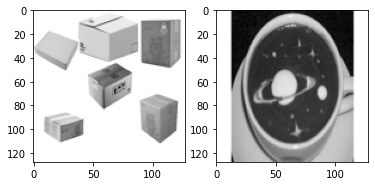

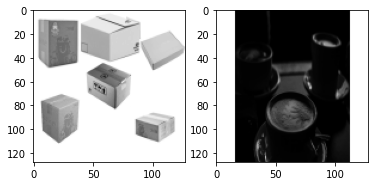

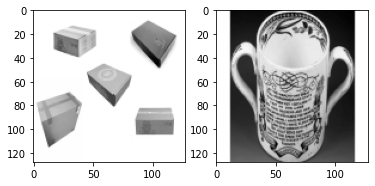

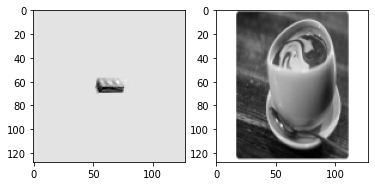

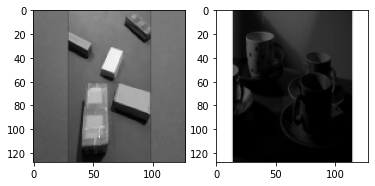

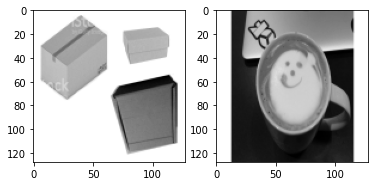

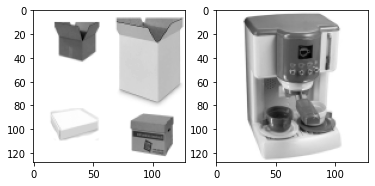

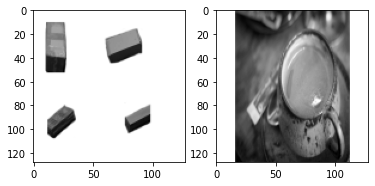

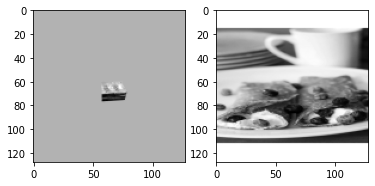

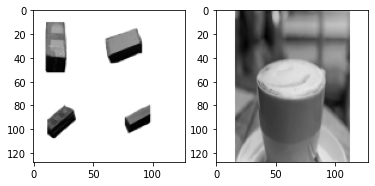

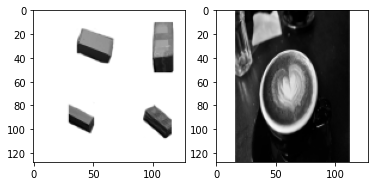

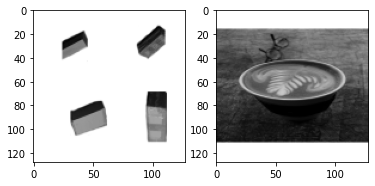

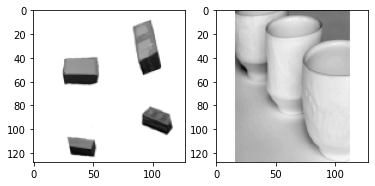

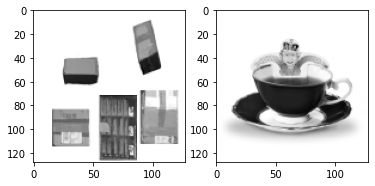

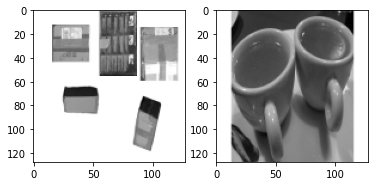

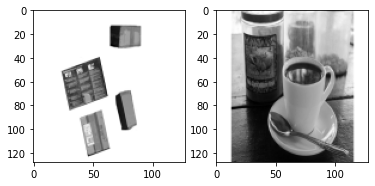

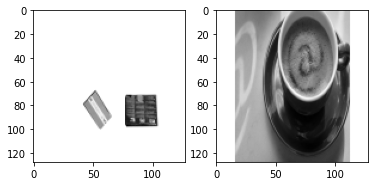

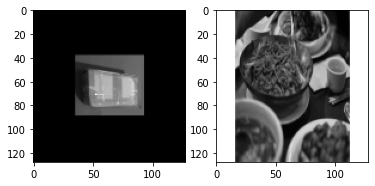

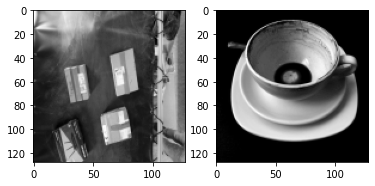

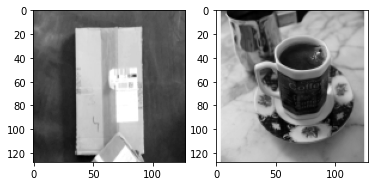

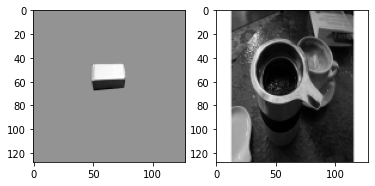

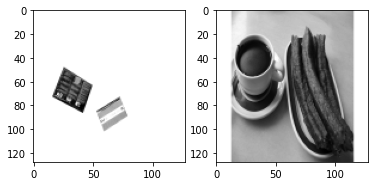

In [237]:
for i in range(100):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.imshow(cb_altered_images[i], cmap="gray")
    ax2.imshow(cup_altered_images[i], cmap="gray")
    #fig.show();